# Unsupervised Learning

## Tomotopy LDA (Latent Dirichlet Allocation)

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

import sys
import os

import gensim
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import corpus2csc

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

import tomotopy as tp

from preprocess import preprocess, tokenizer, stopword_list

In [2]:
data_root = '../data/cvt/'
df = pd.read_csv(os.path.join(data_root, 'covidvaccine.csv'))
df

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,hashtag_count
0,Ashwin,India 🇮🇳,I'm Just A Man On a Mission For My Vision!\n\n...,2018-01-08 06:01:00,89.0,3108.0,6780.0,0,2020-08-09 19:15:00,Huge Thanks And Best Wishes With @SerumInstInd...,covisheild,Twitter for Android,1
1,K. Kartik Rao,Mumbai and Nagpur India,Actor 🎭 \n\nhttps://t.co/u7GZfoWBDt\n\nSubscri...,2016-12-10 16:06:00,225.0,257.0,25362.0,0,2020-08-09 20:02:00,Any update of #CovidVaccine ????,covidvaccine,Twitter for Android,1
2,Mac Patrick (Road Hater) Henry,German Bundesrepublik,Liberty lover. \nServing the people of the 🇺🇸....,2014-01-11 19:47:00,338.0,277.0,28305.0,0,2020-08-09 21:21:00,From a private frontline COVID nurses group to...,covid19 covidvaccinerace covidvaccine pandemic,Twitter Web App,4
3,lydia Bell,Earth,"Mummy, animal lover , energy worker , awake in...",2009-03-23 01:09:00,2038.0,1105.0,63422.0,0,2020-08-09 21:29:00,So you want the whole world to take a #covidva...,covidvaccine,Twitter for iPhone,1
4,Lou Ann Donovan,"Kansas, USA",Live Young Look Young BE Young! Certified Inte...,2009-03-17 05:42:00,4365.0,4581.0,2505.0,0,2020-08-09 22:55:00,Watch to learn about the Phase 3 clinical tria...,covid19 covidvaccine covidclinicaltrial,Twitter for iPhone,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154533,Script Your Future '21,DMV,HowardU and Script Your Future has joined forc...,2021-01-31 18:40:41,15.0,42.0,4.0,0,2021-02-28 23:55:25,* Continue with routine preventive measures (s...,NaN,Twitter Web App,0
154534,eastvillagetwt,"East Village, New York, NY","Politics, the environment, science, culture, t...",2011-08-27 19:24:17,1968.0,5001.0,136110.0,0,2021-02-28 23:56:37,COVID: California Suspends System Of Shared Va...,covid19 covidvaccine,Twitter for iPhone,2
154535,Yogita,"New York, NY",Primum non nocere 💕👩🏽‍⚕️ | Tweets are my own. ...,2015-08-07 01:48:57,17.0,58.0,1194.0,0,2021-02-28 23:57:00,Today I got my first dose of the #COVIDVaccine...,covidvaccine,Twitter for Android,1
154536,DrZ,USA,NaN,2016-03-23 13:00:36,54.0,4.0,4.0,0,2021-02-28 23:57:06,Here's Where to Receive a COVID Vaccine in Ill...,illinois covidvaccine,Buffer,2


In [3]:
df['text'] = df['text'].apply(lambda x: preprocess(x))

df

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,hashtag_count
0,Ashwin,India 🇮🇳,I'm Just A Man On a Mission For My Vision!\n\n...,2018-01-08 06:01:00,89.0,3108.0,6780.0,0,2020-08-09 19:15:00,huge thanks best wishes seruminstindia adarpoo...,covisheild,Twitter for Android,1
1,K. Kartik Rao,Mumbai and Nagpur India,Actor 🎭 \n\nhttps://t.co/u7GZfoWBDt\n\nSubscri...,2016-12-10 16:06:00,225.0,257.0,25362.0,0,2020-08-09 20:02:00,update covidvaccine,covidvaccine,Twitter for Android,1
2,Mac Patrick (Road Hater) Henry,German Bundesrepublik,Liberty lover. \nServing the people of the 🇺🇸....,2014-01-11 19:47:00,338.0,277.0,28305.0,0,2020-08-09 21:21:00,private frontline covid nurses group today cov...,covid19 covidvaccinerace covidvaccine pandemic,Twitter Web App,4
3,lydia Bell,Earth,"Mummy, animal lover , energy worker , awake in...",2009-03-23 01:09:00,2038.0,1105.0,63422.0,0,2020-08-09 21:29:00,want whole world take covidvaccine s fast trac...,covidvaccine,Twitter for iPhone,1
4,Lou Ann Donovan,"Kansas, USA",Live Young Look Young BE Young! Certified Inte...,2009-03-17 05:42:00,4365.0,4581.0,2505.0,0,2020-08-09 22:55:00,watch learn phase clinical trial covid vaccine...,covid19 covidvaccine covidclinicaltrial,Twitter for iPhone,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154533,Script Your Future '21,DMV,HowardU and Script Your Future has joined forc...,2021-01-31 18:40:41,15.0,42.0,4.0,0,2021-02-28 23:55:25,continue routine preventive measures vaccinati...,NaN,Twitter Web App,0
154534,eastvillagetwt,"East Village, New York, NY","Politics, the environment, science, culture, t...",2011-08-27 19:24:17,1968.0,5001.0,136110.0,0,2021-02-28 23:56:37,covid california suspends system shared vaccin...,covid19 covidvaccine,Twitter for iPhone,2
154535,Yogita,"New York, NY",Primum non nocere 💕👩🏽‍⚕️ | Tweets are my own. ...,2015-08-07 01:48:57,17.0,58.0,1194.0,0,2021-02-28 23:57:00,today got first dose covidvaccine super thankful,covidvaccine,Twitter for Android,1
154536,DrZ,USA,NaN,2016-03-23 13:00:36,54.0,4.0,4.0,0,2021-02-28 23:57:06,heres receive covid vaccine illinois illinois ...,illinois covidvaccine,Buffer,2


In [4]:
df['text']

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         huge thanks best wishes seruminstindia adarpoo...
1                                       update covidvaccine
2         private frontline covid nurses group today cov...
3         want whole world take covidvaccine s fast trac...
4         watch learn phase clinical trial covid vaccine...
                                ...                        
154533    continue routine preventive measures vaccinati...
154534    covid california suspends system shared vaccin...
154535     today got first dose covidvaccine super thankful
154536    heres receive covid vaccine illinois illinois ...
154537    utah slc sold walmart vaccine first dose book ...
Name: text, Length: 154538, dtype: object

In [5]:
# Prepare corpus
def get_tp_corpus(docs):
    porter_stemmer = nltk.PorterStemmer().stem
    english_stops = set(porter_stemmer(w) for w in stopwords.words('english'))
    tp_corpus = tp.utils.Corpus(
        tokenizer=tp.utils.SimpleTokenizer(porter_stemmer), 
        stopwords=lambda x: x in english_stops
    )
    tp_corpus.process(d.lower() for d in docs)
    return tp_corpus

tp_corpus = get_tp_corpus(list(df['text']))

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def compute_coherence_values_tp(tp_corpus, k, a, b):
    lda_model = tp.LDAModel(k=k,alpha=a,eta=b,corpus=tp_corpus)
    lda_model.train(500)
    co_mass = tp.coherence.Coherence(lda_model,coherence="u_mass")
    co_cv = tp.coherence.Coherence(lda_model,coherence="c_v")
    return co_mass.get_score(), co_cv.get_score()

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
already_run = True

# Topics range (length = 10)
min_topics = 2
max_topics = 22
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter (length = 5)
alpha = list(np.arange(0.01, 1, 0.1))

# Beta parameter (length = 5)
beta = list(np.arange(0.01, 1, 0.1))

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence_cv': [],
                 "Coherence_umass":[],
                }

if not already_run:
    # Can take a long time to run
    pbar = tqdm.tqdm(total=2200)
    
    # Iterate through number of topics
    for k in topics_range:
        # Iterate through alpha values
        for a in alpha:
            # Iterate through beta values
            for b in beta:
                # Get the coherence score for the given parameters
                umass,cv = compute_coherence_values_tp(tp_corpus=tp_corpus,k=k, a=a, b=b)
                #print(umass,cv)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence_cv'].append(cv)
                model_results['Coherence_umass'].append(umass)


                pbar.update(1)
    coherence_results = pd.DataFrame(model_results)
    coherence_results.to_csv('../out/lda_tuning_results.csv', index=False)
    pbar.close()
else:
    coherence_results = pd.read_csv('../out/lda_tuning_results.csv')

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Sort coherence_results
sorted_coherence_results = coherence_results.sort_values(by=['Coherence_cv', 'Coherence_umass'], ascending=False)
sorted_coherence_results

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topics,Alpha,Beta,Coherence_cv,Coherence_umass
1809,20,0.01,0.91,0.934071,-12.548957
1879,20,0.71,0.91,0.933534,-11.583615
1888,20,0.81,0.81,0.933502,-12.632436
1839,20,0.31,0.91,0.933187,-14.247271
1949,21,0.41,0.91,0.932608,-12.058181
...,...,...,...,...,...
17,2,0.11,0.71,0.307607,-2.794608
7,2,0.01,0.71,0.307535,-2.925011
112,3,0.11,0.21,0.307470,-2.948469
6,2,0.01,0.61,0.306032,-2.824641


In [9]:
import dataframe_image as dfi
dfi.export(sorted_coherence_results, "../img/sorted_lda_coherence.png", max_rows=10)

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# View the top coherence result
best_hyperparams = sorted_coherence_results.iloc[0]
best_hyperparams

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics             20.000000
Alpha               0.010000
Beta                0.910000
Coherence_cv        0.934071
Coherence_umass   -12.548957
Name: 1809, dtype: float64

In [11]:
mdl = tp.LDAModel(
    k=int(best_hyperparams['Topics']),
    corpus=tp_corpus,
    alpha=best_hyperparams['Alpha'],
    eta=best_hyperparams['Beta']
)

mdl.train(500)

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
mdl.summary()

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency
)

pyLDAvis.save_html(prepared_data, '../out/ldavis.html')

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Basic Info>
| LDAModel (current version: 0.11.1)
| 154535 docs, 1531044 words
| Total Vocabs: 76786, Used Vocabs: 76786
| Entropy of words: -7.72703
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.93086
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.01] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.91 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2281304570 (random seed)
| trained in version 0.11.1
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [9.2070587e-03 1.2136191e-02 4.8965844e-04 4.

In [13]:
rows = {}

for i in range(int(best_hyperparams['Topics'])):
    topic_words = mdl.get_topic_words(i)
    rows['Topic #' + str(i)] = [w for w, p in topic_words]

topic_words = pd.DataFrame.from_dict(rows, orient='index',
                       columns=['Keyword #1', 'Keyword #2', 'Keyword #3', 'Keyword #4', 'Keyword #5',
                               'Keyword #6', 'Keyword #7', 'Keyword #8', 'Keyword #9', 'Keyword #10'])
topic_words

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Keyword #1,Keyword #2,Keyword #3,Keyword #4,Keyword #5,Keyword #6,Keyword #7,Keyword #8,Keyword #9,Keyword #10
Topic #0,mondaynightibd,dcharabati,dr_fcalderaibd,dboss,mregueiromd,edwardloftu,abbvi,mchiorean,sarkaruvaaripaata,spreadboss
Topic #1,terror,vatican,jesuit,_,footwearmal,_the,markofthebeast,nowplay,destruct,von
Topic #2,ukparlia,ukhouseoflord,mojgovuk,uksupremecourt,houseofcommon,shahid_mosardar,downingstreet,meriyaadainc,bme_dementia,abbasshuhala
Topic #3,lctx,lineagecel,ceo_culley,eveningstandard,rickanderson,canadainindia,eriq,terryglavin,nspector,acoyn
Topic #4,thankyou,sheikhhasina,hpm,shortest,bangladeshi,arrang,ge,lucki,gem_ston,ussportsacademi
Topic #5,noorchashm,doritmi,jaikanta,bdsupperclub,ajonschultz,jdcburnhil,dbdbdobson,robertkennedyjr,gerrishaftel,kwstark
Topic #6,educ,redfor,ape,tbat,top,banana,headlin,big,reopenschoolssaf,januari
Topic #7,goblin,frog,iqoo,iqoopro,toad,samsung,realm,hindi,rdayparad,xiaomi
Topic #8,mask,premium,glass,flamingo,foggi,face,coviduk,solut,bompi,tortilli
Topic #9,year,postpon,tokyoolymp,parisolymp,laolymp,pleas,hello,nbcnew,nbcolymp,janon


In [14]:
token_counts = mdl.get_count_by_topics()
topic_words.insert(0, 'Token Counts', token_counts)
topic_words

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Token Counts,Keyword #1,Keyword #2,Keyword #3,Keyword #4,Keyword #5,Keyword #6,Keyword #7,Keyword #8,Keyword #9,Keyword #10
Topic #0,3932,mondaynightibd,dcharabati,dr_fcalderaibd,dboss,mregueiromd,edwardloftu,abbvi,mchiorean,sarkaruvaaripaata,spreadboss
Topic #1,6855,terror,vatican,jesuit,_,footwearmal,_the,markofthebeast,nowplay,destruct,von
Topic #2,361,ukparlia,ukhouseoflord,mojgovuk,uksupremecourt,houseofcommon,shahid_mosardar,downingstreet,meriyaadainc,bme_dementia,abbasshuhala
Topic #3,957,lctx,lineagecel,ceo_culley,eveningstandard,rickanderson,canadainindia,eriq,terryglavin,nspector,acoyn
Topic #4,4012,thankyou,sheikhhasina,hpm,shortest,bangladeshi,arrang,ge,lucki,gem_ston,ussportsacademi
Topic #5,516,noorchashm,doritmi,jaikanta,bdsupperclub,ajonschultz,jdcburnhil,dbdbdobson,robertkennedyjr,gerrishaftel,kwstark
Topic #6,4644,educ,redfor,ape,tbat,top,banana,headlin,big,reopenschoolssaf,januari
Topic #7,81,goblin,frog,iqoo,iqoopro,toad,samsung,realm,hindi,rdayparad,xiaomi
Topic #8,4665,mask,premium,glass,flamingo,foggi,face,coviduk,solut,bompi,tortilli
Topic #9,11933,year,postpon,tokyoolymp,parisolymp,laolymp,pleas,hello,nbcnew,nbcolymp,janon


In [15]:
topic_words.to_csv('../out/lda_topic_words.csv', index=True)

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
import dataframe_image as dfi
dfi.export(topic_words, "../img/lda_topic_words.png", max_rows=20)

/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/andrewchen/anaconda3/envs/ml_proj/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


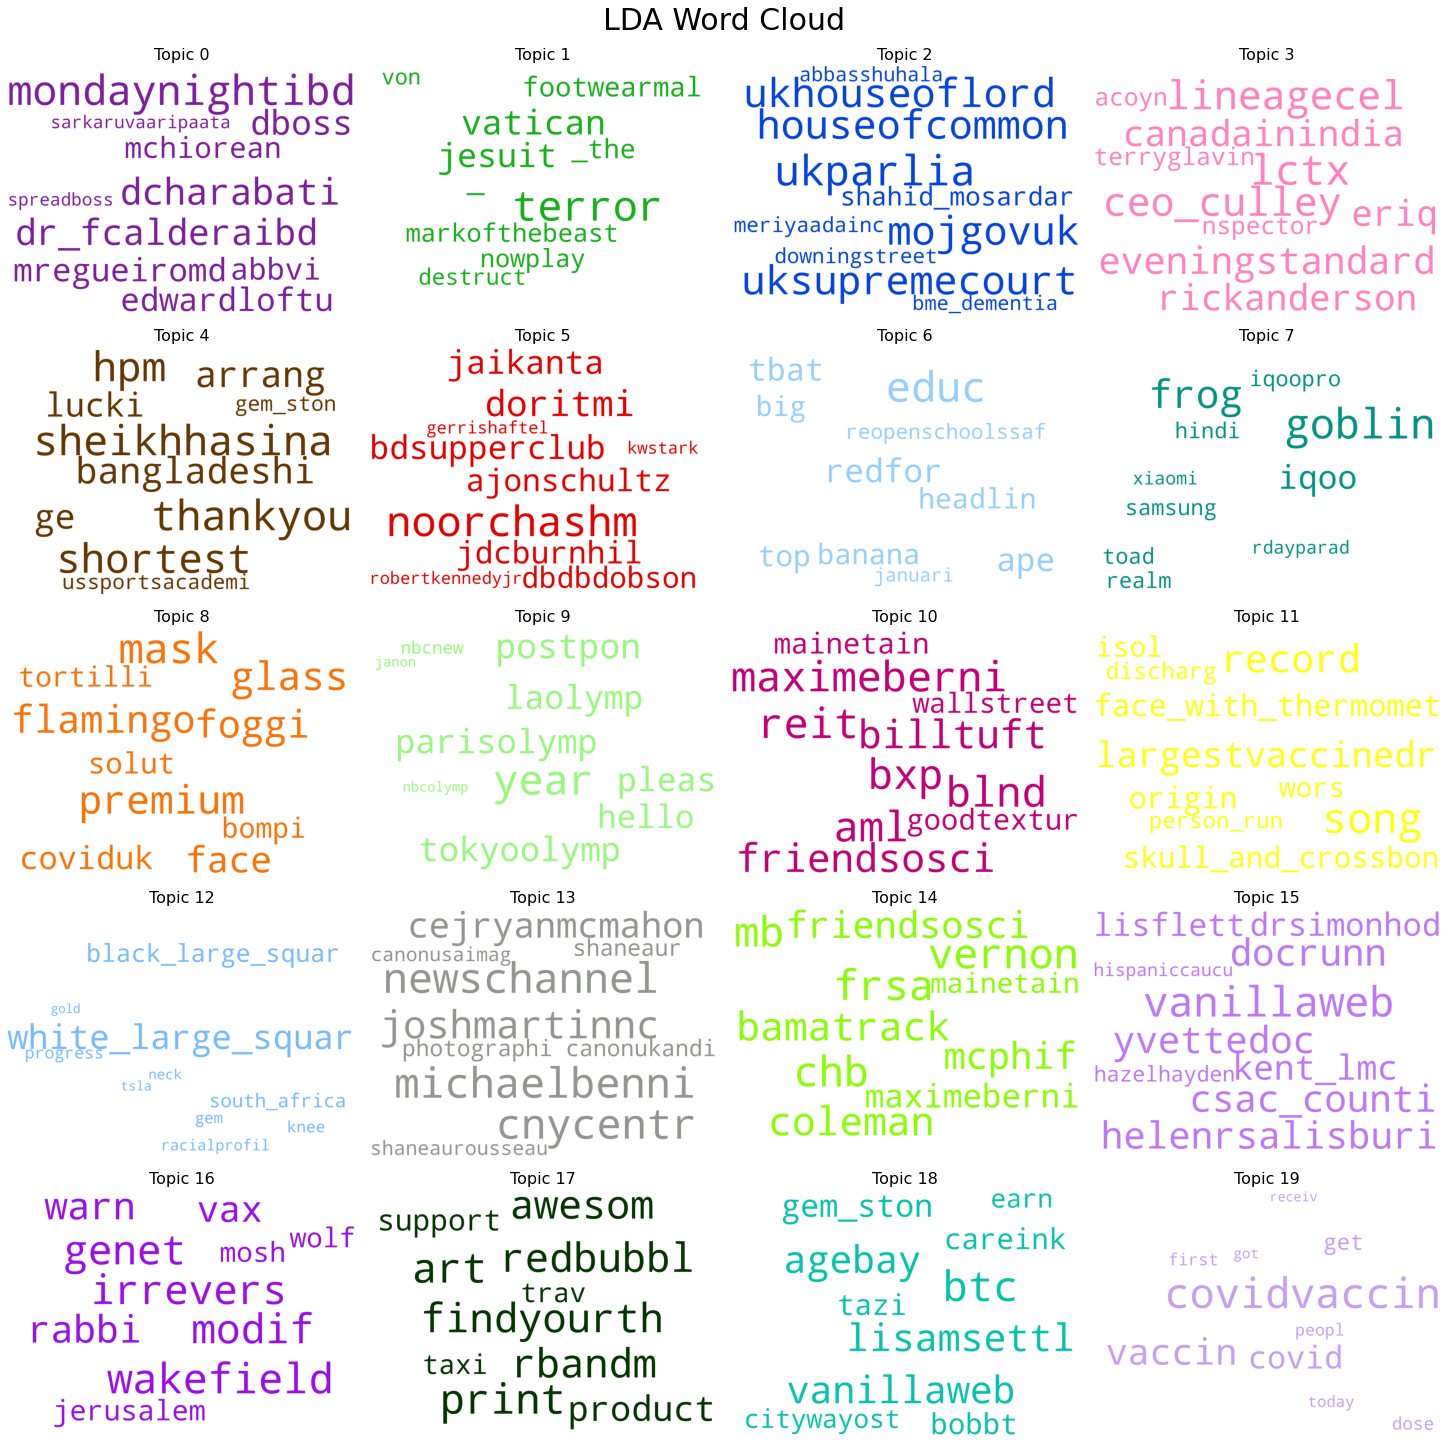

In [24]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()][::-1]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(5, 4, figsize=(20,20), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle("LDA Word Cloud", fontsize=30)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(mdl.get_topic_words(i, top_n=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.savefig("../img/lda_wordcloud.png", facecolor='w', transparent=False, bbox_inches='tight')